# 1. Import the libraries

In [ ]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# 2. Load the dataset and add headers

In [ ]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('/content/Electronics.csv',names=columns)

In [ ]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1.026864e+09
1,0060009810,A3P0KRKOBQK1KN,5.0,1.025914e+09
2,0060009810,A192HO2ICJ75VU,5.0,1.025654e+09
3,0060009810,A2T278FKFL3BLT,4.0,1.025395e+09
4,0060009810,A2ZUXVTW8RXBXW,5.0,1.025222e+09


#### Dropping the timestamp column

In [ ]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [ ]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130792 entries, 0 to 1130791
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1130792 non-null  object 
 1   productId  1130791 non-null  object 
 2   ratings    1130791 non-null  float64
dtypes: float64(1), object(2)
memory usage: 25.9+ MB


In [ ]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  1130792
Number of columns:  3


In [ ]:
#Check the datatypes
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [ ]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:50000,0:]

* Since the data is very big. Consider electronics_df1 named dataframe with  first 50000 rows and all columns from 0 of dataset.

In [ ]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     50000 non-null  object 
 1   productId  50000 non-null  object 
 2   ratings    50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe()

count    50000.000000
mean         4.123980
std          1.343386
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [ ]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


* Rating are on the scale 1 to 5.

# Handling Missing values

In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    1
ratings      1
dtype: int64


* There are no missing records in the dataset.

## Ratings

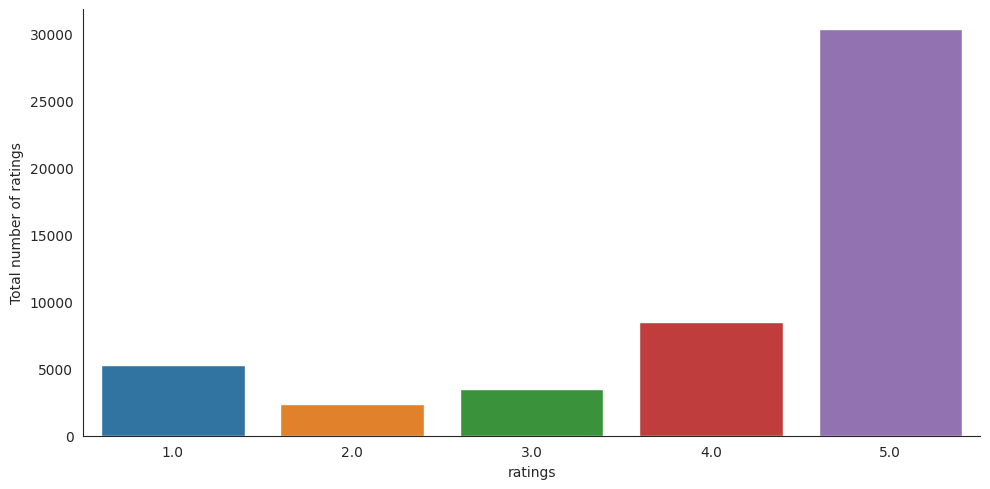

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(data=electronics_df1, x="ratings", aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

* We can see that more number of users have given the rating of 5.

## Users and products

In [ ]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  669
Number of unique product in Raw data =  48682


# 3. Taking the subset of dataset to make it less sparse/ denser.

In [ ]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
B00001P4ZH    3394
B00001WRSJ    2800
1495443043    1803
0972683275    1456
B00000K135    1371
B00000K2YR    1239
6073894996    1217
B00001P4XA    1069
9573212919    1008
B00001P4XH     952
dtype: int64


In [ ]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 47978
Number of unique users in the final data =  333
Number of unique products in the final data =  333


* electronics_df1_final has the users who have rated 25 or more items.

## ratings analysis in final dataset

In [ ]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
userId,,,,,,,,,,,,,,,,,,,,,
0060786817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0101635370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0151004714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0373250460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0375503757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [ ]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (333, 46806)


* We can see that there are 7 products and 236 users.

In [ ]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  47859
possible_num_of_ratings =  15586398
density: 0.31%


* The density value of the matrix also shows that it is a sparse matrix.

# 4. Splitting the data

In [ ]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
23534,B00000J1T1,A1OQCC7IDGPIF5,5.0
20952,B000001OM5,A335QPS69X83J5,5.0
45373,B00001W0DI,A2JA2LPXKLD93Z,2.0
28664,B00000J1V5,A3FAVTVI5QG121,5.0
18351,9983039281,A3J631XKOM5JUC,5.0


In [ ]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (33584, 3)
Shape of testing data:  (14394, 3)


# 5. Building Popularity Recommder model

In [ ]:
#Count of user_id for each unique product as recommendation score
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,A0273990TGLE0LLF0H0B,1
1,A0293130VTX2ZXA70JQS,1
2,A0317784S04NV8QVY364,1
3,A0385843DE41TCVXH2I1,1
4,A0821988FXKFYX53V4QG,1
5,A1003EYWAQFOUG,1
6,A1005332P0RIWL,1
7,A1008Z48LB2QI4,1
8,A100AQOVAMS0P9,1
9,A100B7JCCGVUK8,1


In [ ]:
#Sort the products on recommendation score
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])

#Generate a recommendation rank based upon score
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

#Get the top 5 recommendations
popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,productId,score,rank
10086,A25E8V5JMW43RY,8,1.0
29026,AJJV9Z17KV6GR,6,2.0
13765,A2L7WYA5OENV03,5,3.0
19811,A3A15L96IYUO6V,5,4.0
345,A11ED8O95W2103,4,5.0


In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):
    user_recommendations = popularity_recommendations

    #Add user_id column for which the recommendations are being generated
    user_recommendations['userId'] = user_id

    #Bring user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [ ]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))
    print("\n")

The list of recommendations for the userId: 10

       userId       productId  score  rank
10086      10  A25E8V5JMW43RY      8   1.0
29026      10   AJJV9Z17KV6GR      6   2.0
13765      10  A2L7WYA5OENV03      5   3.0
19811      10  A3A15L96IYUO6V      5   4.0
345        10  A11ED8O95W2103      4   5.0


The list of recommendations for the userId: 100

       userId       productId  score  rank
10086     100  A25E8V5JMW43RY      8   1.0
29026     100   AJJV9Z17KV6GR      6   2.0
13765     100  A2L7WYA5OENV03      5   3.0
19811     100  A3A15L96IYUO6V      5   4.0
345       100  A11ED8O95W2103      4   5.0


The list of recommendations for the userId: 150

       userId       productId  score  rank
10086     150  A25E8V5JMW43RY      8   1.0
29026     150   AJJV9Z17KV6GR      6   2.0
13765     150  A2L7WYA5OENV03      5   3.0
19811     150  A3A15L96IYUO6V      5   4.0
345       150  A11ED8O95W2103      4   5.0




* Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# 6. Building Collaborative Filtering recommender model.

In [ ]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,23534,B00000J1T1,A1OQCC7IDGPIF5,5.0
1,20952,B000001OM5,A335QPS69X83J5,5.0
2,45373,B00001W0DI,A2JA2LPXKLD93Z,2.0
3,28664,B00000J1V5,A3FAVTVI5QG121,5.0
4,18351,9983039281,A3J631XKOM5JUC,5.0


## User Based Collaborative Filtering model

In [ ]:
# Matrix with row per 'user' and column per 'item'
pivot_df = electronics_df_CF.pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
userId,,,,,,,,,,,,,,,,,,,,,
0060786817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0101635370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0151004714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0373250460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0375503757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (333, 46806)


In [ ]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896,user_index
userId,,,,,,,,,,,,,,,,,,,,,
0060786817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0101635370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0151004714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
0373250460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
0375503757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [ ]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df.to_numpy(), k = 10)

In [ ]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-2.22044605e-16 -1.89159222e-16 -5.65174117e-16 ...  2.10352700e-16
  -6.99091616e-16 -7.26547915e-17]
 [-2.08050835e-17 -4.75729297e-30 -8.02309608e-17 ...  3.00205417e-17
  -9.40003284e-17 -1.08149167e-17]
 [-2.35679772e-17 -2.59273517e-17 -2.22044605e-16 ...  2.86371455e-17
  -9.55972485e-17 -9.98895266e-18]
 ...
 [-2.13320653e-09  6.54046345e-08  3.59866913e-08 ... -2.68629540e-11
   1.80697106e-09 -3.20792692e-08]
 [-1.20861373e-07  3.31219168e-06  5.95103633e-08 ... -1.34964263e-09
  -1.60513640e-04 -9.27035925e-05]
 [-6.41210019e-05 -2.32572869e-03  5.69790290e-06 ... -1.91014156e-09
  -8.14927772e-04 -3.68838744e-05]]


In [ ]:
print('Sigma: \n',sigma)

Sigma: 
 [127.0963038  130.94786041 131.0947473  134.63686447 145.86408269
 170.36605481 175.90673917 196.45384391 248.16804891 266.27649493]


* As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [ ]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[127.0963038    0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         130.94786041   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.         131.0947473    0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         134.63686447   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         145.86408269
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  170.36605481   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         175.90673917   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [ ]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 0.00000000e+00 -8.74712953e-07  2.16008544e-19 ... -1.69619098e-09
   3.14562030e-02 -2.34528372e-09]
 [-1.99222149e-17 -3.15909690e-05  4.44301702e-20 ... -2.46965963e-08
  -7.57761296e-04 -7.97590128e-08]
 [ 1.73039567e-18  7.42788615e-08 -3.30011876e-27 ...  1.96952944e-09
   1.94031477e-06  1.87200063e-10]
 ...
 [-5.30065381e-19 -6.64483674e-12 -2.54506931e-20 ...  1.35720809e-12
  -3.12661420e-12 -8.15903328e-15]
 [ 3.92507127e-19  1.58516463e-08  2.11678827e-19 ... -9.70022389e-06
   4.22062811e-07 -2.24400502e-09]
 [ 1.22073330e-18 -3.00672795e-07 -5.90805347e-20 ... -3.70930544e-07
  -6.91287712e-06 -9.01122466e-11]]


In [ ]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
0,6.049545e-31,8.141047e-19,-6.729178e-32,5.583748e-19,-1.797710e-17,-2.299578e-18,-1.043113e-15,-1.149789e-17,3.014535e-21,1.676397e-15,...,2.882794e-18,1.730985e-21,6.024892e-18,3.872156e-18,-1.097141e-18,2.969863e-16,5.939726e-16,1.695903e-18,-8.686213e-16,2.439738e-21
1,2.828428e-33,6.391316e-21,-8.216493e-33,5.979931e-20,-1.771880e-18,-3.279573e-19,-1.282380e-16,-1.639787e-18,3.441048e-22,1.712379e-16,...,3.538078e-19,5.132385e-23,1.607897e-19,3.958646e-19,-1.383841e-19,4.200481e-17,8.400962e-17,2.277859e-19,-8.292487e-17,6.713171e-23
2,4.924680e-32,1.097284e-19,-9.037755e-33,5.689183e-20,-2.126574e-18,-9.070942e-19,-1.383880e-16,-4.535471e-18,4.115397e-22,2.285165e-16,...,3.935191e-19,2.337732e-22,6.289602e-19,4.747146e-19,-1.461620e-19,4.023039e-17,8.046078e-17,2.318564e-19,-9.162176e-17,3.294250e-22
3,5.689245e-32,3.927489e-20,-9.176477e-33,5.417669e-20,-1.941321e-18,-1.447205e-19,-9.098543e-17,-7.236024e-19,4.181488e-22,3.351199e-16,...,3.887190e-19,1.416715e-22,3.637345e-19,5.623710e-19,-9.447986e-20,8.355316e-18,1.671063e-17,1.654669e-19,-9.733930e-17,1.370570e-22
4,-6.518837e-31,-3.653219e-19,9.392932e-32,-5.716527e-19,2.058993e-17,1.639093e-18,1.021034e-15,8.195464e-18,-4.460042e-21,-3.574544e-15,...,-4.142238e-18,-1.422546e-21,-3.535223e-18,-5.969298e-18,1.053741e-18,-2.220083e-16,-4.440166e-16,-1.782563e-18,1.027460e-15,-1.337616e-21


In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0
    user_idx = userID-1
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
A3PA30MQ4DN3OS              0.0      3.830859e-16
A2B68O81ICJJLL              0.0      3.830859e-16
A979ON3H1O593               0.0      3.509441e-16
A3M5OYNZ2A5E0O              0.0      3.423041e-16
A28X0LT2100RL1              0.0      3.421516e-16


In [ ]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
A157UO8K6YEGDZ              0.0          0.000006
A18HE80910BTZI              0.0          0.000006
AHJQA7TTF5BFC               0.0          0.000006
AHRXG1I39B1FR               0.0          0.000006
A6C0EPRJRIXVE               0.0          0.000006


In [ ]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
A4GGT6O0GQNV2               0.0      3.103347e-16
A2NA9VZN5VA9GW              0.0      3.102100e-16
A2F6MS855IL5VS              0.0      3.102100e-16
A3ORZG0RL3JIPJ              0.0      3.102100e-16
A1YRUUY14KW853              0.0      3.102100e-16


* Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# 7. Evaluation of Collabrative recommendation model

In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
userId,,,,,,,,,,,,,,,,,,,,,
0060786817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0101635370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0151004714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0373250460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0375503757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
A01821029CN62H06UXO     0.009009
A0219337RHNC3U3T12TP    0.015015
A0232781HWIYKC30FDSP    0.003003
A0266076X6KPZ6CCHGVS    0.015015
A0273990TGLE0LLF0H0B    0.015015
dtype: float64

In [ ]:
# Predicted ratings
preds_df.head()

productId,A01821029CN62H06UXO,A0219337RHNC3U3T12TP,A0232781HWIYKC30FDSP,A0266076X6KPZ6CCHGVS,A0273990TGLE0LLF0H0B,A0289418QDN9OTXLUDEK,A0293130VTX2ZXA70JQS,A0317784S04NV8QVY364,A0385843DE41TCVXH2I1,A05308081UG71LSV3EE3,...,AZZGJ2KMWB7R,AZZGUU97OHUF1,AZZP8BC9WE0N8,AZZST8OYL5P4Q,AZZT9G4MJFCHD,AZZUO98LB93B2,AZZVYHVJ8BDUZ,AZZW390GP15LN,AZZXJAE2DILET,AZZYJH0XNZ896
0,6.049545e-31,8.141047e-19,-6.729178e-32,5.583748e-19,-1.797710e-17,-2.299578e-18,-1.043113e-15,-1.149789e-17,3.014535e-21,1.676397e-15,...,2.882794e-18,1.730985e-21,6.024892e-18,3.872156e-18,-1.097141e-18,2.969863e-16,5.939726e-16,1.695903e-18,-8.686213e-16,2.439738e-21
1,2.828428e-33,6.391316e-21,-8.216493e-33,5.979931e-20,-1.771880e-18,-3.279573e-19,-1.282380e-16,-1.639787e-18,3.441048e-22,1.712379e-16,...,3.538078e-19,5.132385e-23,1.607897e-19,3.958646e-19,-1.383841e-19,4.200481e-17,8.400962e-17,2.277859e-19,-8.292487e-17,6.713171e-23
2,4.924680e-32,1.097284e-19,-9.037755e-33,5.689183e-20,-2.126574e-18,-9.070942e-19,-1.383880e-16,-4.535471e-18,4.115397e-22,2.285165e-16,...,3.935191e-19,2.337732e-22,6.289602e-19,4.747146e-19,-1.461620e-19,4.023039e-17,8.046078e-17,2.318564e-19,-9.162176e-17,3.294250e-22
3,5.689245e-32,3.927489e-20,-9.176477e-33,5.417669e-20,-1.941321e-18,-1.447205e-19,-9.098543e-17,-7.236024e-19,4.181488e-22,3.351199e-16,...,3.887190e-19,1.416715e-22,3.637345e-19,5.623710e-19,-9.447986e-20,8.355316e-18,1.671063e-17,1.654669e-19,-9.733930e-17,1.370570e-22
4,-6.518837e-31,-3.653219e-19,9.392932e-32,-5.716527e-19,2.058993e-17,1.639093e-18,1.021034e-15,8.195464e-18,-4.460042e-21,-3.574544e-15,...,-4.142238e-18,-1.422546e-21,-3.535223e-18,-5.969298e-18,1.053741e-18,-2.220083e-16,-4.440166e-16,-1.782563e-18,1.027460e-15,-1.337616e-21


In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
A01821029CN62H06UXO     8.846681e-18
A0219337RHNC3U3T12TP    1.337302e-05
A0232781HWIYKC30FDSP   -2.562438e-19
A0266076X6KPZ6CCHGVS    4.645136e-06
A0273990TGLE0LLF0H0B    2.474202e-04
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(46806, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
A01821029CN62H06UXO,0.009009,8.846681e-18,0
A0219337RHNC3U3T12TP,0.015015,1.337302e-05,1
A0232781HWIYKC30FDSP,0.003003,-2.562438e-19,2
A0266076X6KPZ6CCHGVS,0.015015,4.645136e-06,3
A0273990TGLE0LLF0H0B,0.015015,2.474202e-04,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01083 



# 8. Getting top - K ( K = 5) recommendations.

In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
A2B68O81ICJJLL              0.0          0.000011
A3PA30MQ4DN3OS              0.0          0.000011
A3LAPQWMLWTYRK              0.0          0.000006
AXJWF8U17YEHO               0.0          0.000006
A372RI2EVSAYNS              0.0          0.000006


# Summarising insights.

* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.